### Exercici 1:

Implementeu un filtre de Bloom fent servir funcions hash independents. Com a mínim, és necessari poder especificar la mida del filtre i el número de funcions hash, i cal poder afegir nous
elements al filtre i comprovar la inclusió d’elements al filtre. Addicionalment, implementeu funcions per desar el filtre a disc i carregar un filtre desat.


In [1]:
import mmh3
import math
import bitarray
import hashlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import time
import os

class BloomFilter:
    def __init__(self, size, num_hashes):
        self.size = size
        self.num_hashes = num_hashes
        self.bit_array = bitarray.bitarray(size)
        self.bit_array.setall(0)
    
    def _hashes(self, item):
        return [mmh3.hash(item, i) % self.size for i in range(self.num_hashes)]
    
    def add(self, item):
        for hash_value in self._hashes(item):
            self.bit_array[hash_value] = 1
    
    def check(self, item):
        return all(self.bit_array[hash_value] for hash_value in self._hashes(item))
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)

### Exercici 2:

Seleccioneu un subconjunt de contrasenyes del dataset total i fixeu una mida per al filtre de Bloom. Creeu diversos filtres de Bloom amb diferents quantitats de funcions hash (diferents
valors de k) i afegiu els elements del subconjunt de contrasenyes seleccionat a cadascun dels
filtres.

Calculeu la taxa de falsos positius experimental i teòricament per a cada un dels filtres i genereu
una gràfica que mostri com evoluciona la probabilitat de falsos positius (a nivell teòric i experimental) en funció de k.

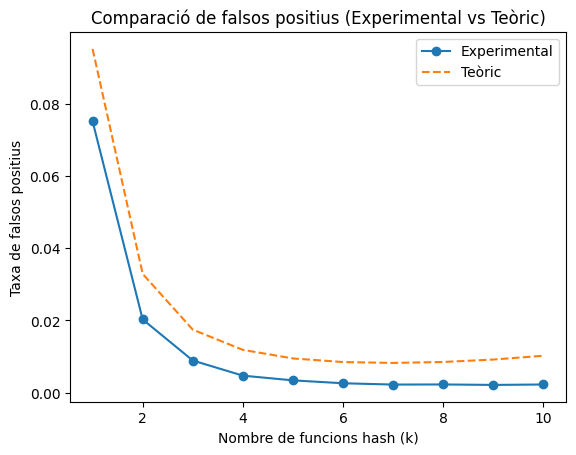

In [2]:
def false_positive_rate(n, m, k):
    return (1 - np.exp(-k * n / m)) ** k

# Càrrega del dataset
def load_passwords(base_folder, num_samples):
    passwords = []
    
    for root, _, files in os.walk(base_folder):  # Recórrer totes les carpetes i subcarpetes
        for filename in files:
            filepath = os.path.join(root, filename)  # Camí complet al fitxer
            with open(filepath, 'r', encoding='utf-8', errors='ignore') as file:
                for line in file:
                    parts = line.strip().split(':')
                    if len(parts) == 2:
                        passwords.append(parts[1])  # Agafem només la contrasenya
                        if num_samples != 0 and len(passwords) >= num_samples:
                            return passwords  # Tornem la llista quan arribem al límit

    return passwords  

# Paràmetres de prova
n = 100_000  # Nombre de contrasenyes
m = 10 * n  # Mida del filtre de Bloom
k = 10  # Nombre de funcions hash
base_folder = "dataset"
passwords = load_passwords(base_folder, n)

# Experiment per diferents valors de k
k_values = list(range(1, k + 1))
false_positive_rates_exp = []
false_positive_rates_theo = []

for k in k_values:
    bf = BloomFilter(m, k)
    for password in passwords:
        bf.add(password)
    
    # Comprovació amb contrasenyes que no haurien d'estar
    test_passwords = [f"fakepass{i}" for i in range(n)]
    false_positives = sum(1 for p in test_passwords if bf.check(p))
    false_positive_rates_exp.append(false_positives / n)
    false_positive_rates_theo.append(false_positive_rate(n, m, k))

# Generació de la gràfica
plt.plot(k_values, false_positive_rates_exp, label="Experimental", marker='o')
plt.plot(k_values, false_positive_rates_theo, label="Teòric", linestyle='dashed')
plt.xlabel("Nombre de funcions hash (k)")
plt.ylabel("Taxa de falsos positius")
plt.title("Comparació de falsos positius (Experimental vs Teòric)")
plt.legend()
plt.show()

### Exercici 3:

Implementeu una funció que seleccioni la mida òptima del filtre i el nombre de funcions de hash
a partir del nombre esperat d’elements i la taxa de falsos positius desitjada.

In [3]:
def calcular_parametres_bloom(n, p): #--> (m, k)

    m = - (n * math.log(p)) / (math.log(2) ** 2)
    k = (m / n) * math.log(2)
    return int(m), int(k)

# Exemple d'ús
n = 1000000 
p = 0.05 
m, k = calcular_parametres_bloom(n, p)
print(f"Mida òptima del filtre: {m} bits")
print(f"Nombre òptim de funcions hash: {k}")

Mida òptima del filtre: 6235224 bits
Nombre òptim de funcions hash: 4


### Exercici 4:

Compareu experimentalment la implementació del filtre de Bloom amb una estructura de dades
no probabilística estàndard (per exemple, un conjunt o una llista).
Compareu les dues estructures en base a les 4 mètriques següents:

- temps d’afegir elements al filtre
- temps de comprovar la pertinença d’elements al filtre
- mida de l’estructura de dades
- taxa de falsos positius

Feu la comparació per a 3 conjunts de dades de contrasenyes de diferents mides (per exemple,
1K, 10K, 1M contrasenyes). Podeu agafar subconjunts de contrasenyes del dataset total.

In [4]:
def afegir_bloom(filter_bloom, contrasenyes):
    for contrasenya in contrasenyes:
        filter_bloom.add(contrasenya)

def comprovar_bloom(filter_bloom, contrasenyes):
    [filter_bloom.check(contrasenya) for contrasenya in contrasenyes]

# Definim la funció per crear un conjunt
def afegir_set(conjunt, contrasenyes):
    conjunt.update(contrasenyes)

def comprovar_set(conjunt, contrasenyes):
    return [contrasenya in conjunt for contrasenya in contrasenyes]

# Carregar les contrasenyes del fitxer
filename = "0"  # Nom del fitxer amb les contrasenyes
passwords_1000 = load_passwords(filename, 1000)
passwords_10000 = load_passwords(filename, 10000)
passwords_1000000 = load_passwords(filename, 1000000)


# Funció per mesurar el temps d'execució per un nombre determinat de contrasenyes
def comparar_estructures(filter_bloom, passwords):
    # Temps per afegir elements al filtre de Bloom
    start_time = time.time()
    afegir_bloom(filter_bloom, passwords)
    print(f"Temps per afegir al Bloom Filter: {time.time() - start_time:.6f} segons")

    # Temps per afegir elements a un conjunt
    start_time = time.time()
    set_contrasenyes = set()
    afegir_set(set_contrasenyes, passwords)
    print(f"Temps per afegir al conjunt (set): {time.time() - start_time:.6f} segons")

    # Temps per comprovar elements al filtre de Bloom
    start_time = time.time()
    comprovacio_bloom = comprovar_bloom(filter_bloom, passwords)
    print(f"Temps per comprovar al Bloom Filter: {time.time() - start_time:.6f} segons")

    # Temps per comprovar elements al conjunt
    start_time = time.time()
    comprovacio_set = comprovar_set(set_contrasenyes, passwords)
    print(f"Temps per comprovar al conjunt (set): {time.time() - start_time:.6f} segons")

    # Mida de les estructures de dades
    print(f"Mida del filtre de Bloom: {filter_bloom.size / 1024 / 1024:.2f} MB")

    return filter_bloom.bit_array

filter_bloom = BloomFilter(size=6235224, num_hashes=4)

# Executar comparativa per a 1000, 10000 i 1000000 contrasenyes
print("Comparativa per a 1000 contrasenyes:")
x = comparar_estructures(filter_bloom, passwords_1000)

print([sum(x)])

"""
print("\nComparativa per a 10000 contrasenyes:")
comparar_estructures(filter_bloom, passwords_10000)

print("\nComparativa per a 1000000 contrasenyes:")
comparar_estructures(filter_bloom, passwords_1000000)"
"""

Comparativa per a 1000 contrasenyes:
Temps per afegir al Bloom Filter: 0.000003 segons
Temps per afegir al conjunt (set): 0.000006 segons
Temps per comprovar al Bloom Filter: 0.000002 segons
Temps per comprovar al conjunt (set): 0.000001 segons
Mida del filtre de Bloom: 5.95 MB
[0]


'\nprint("\nComparativa per a 10000 contrasenyes:")\ncomparar_estructures(filter_bloom, passwords_10000)\n\nprint("\nComparativa per a 1000000 contrasenyes:")\ncomparar_estructures(filter_bloom, passwords_1000000)"\n'

### Exercici 5:

Com haureu pogut observar a l’exercici anterior, el filtre de Bloom és lent afegint elements i
comprovant-ne la pertinençaa al filtre. Una part significativa del temps dedicat a afegir i comprovar
elements s’inverteix en el càlcul de les diverses funcions hash.

Implementeu una nova versió del filtre de Bloom que funcioni amb doble hashing. El doble
hashing utilitza dues funcions de hash, h1 i h2, per generar les múltiples funcions hash necessàries,
gi
, per a implementar el filtre, de manera que:
gi(x) = h1(x) + i · h2(x) mod m
on h1 i h2 s´on funcions de hash independents, i és l’índex de la funció de hash, i més la mida
del filtre.

In [5]:
class BloomFilterDoubleHashing:
    def __init__(self, size, num_hashes):
        self.size = size
        self.num_hashes = num_hashes
        self.bit_array = bitarray.bitarray(size)
        self.bit_array.setall(0)

    def _hashes(self, item):
        h1 = mmh3.hash(item, 42) % self.size  
        h2 = mmh3.hash(item, 84) % self.size  
        return [(h1 + i * h2) % self.size for i in range(self.num_hashes)]  # Doble hashing

    def add(self, item):
        for pos in self._hashes(item):
            self.bit_array[pos] = 1

    def check(self, item):
        return all(self.bit_array[pos] for pos in self._hashes(item))

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)

### Exercici 6:

Compareu la nova implementació del filtre de Bloom amb la primera implementació (és a dir, la
implementació que fa servir la tècnica del doble hashing amb la implementació original, que fa
servir funcions hash independents). Utilitzeu les mateixes 4 mètriques i els mateixos 3 subconjunts de dades utilitzats a l’exercici 4.

Comenteu els resultats obtinguts.

In [6]:
def comparar_estructures(filter_bloom, filter_bloom_dh, passwords):
    # Temps per afegir elements al filtre de Bloom
    start_time = time.time()
    afegir_bloom(filter_bloom, passwords)
    print(f"Temps per afegir al Bloom Filter Simple: {time.time() - start_time:.6f} segons")

    # Temps per afegir elements a un conjunt
    start_time = time.time()
    afegir_bloom(filter_bloom_dh, passwords)
    print(f"Temps per afegir al Bloom Filter Double Hashing: {time.time() - start_time:.6f} segons")

    # Temps per comprovar elements al filtre de Bloom
    start_time = time.time()
    comprovacio_bloom = comprovar_bloom(filter_bloom, passwords)
    print(f"Temps per comprovar al Bloom Filter Simple: {time.time() - start_time:.6f} segons")

    # Temps per comprovar elements al conjunt
    start_time = time.time()
    comprovacio_bloom = comprovar_bloom(filter_bloom_dh, passwords)
    print(f"Temps per comprovar al Bloom Filter Double Hashing: {time.time() - start_time:.6f} segons")

    # Mida de les estructures de dades
    print(f"Mida del filtre de Bloom Simple: {filter_bloom.size / 1024 / 1024:.2f} MB")
    print(f"Mida del filtre de Bloom Double Hashing: {filter_bloom_dh.size / 1024 / 1024:.2f} MB")

# Inicialitzar el filtre de Bloom (si no està inicialitzat al principi)
filter_bloom = BloomFilter(size=6235224, num_hashes=4)  
filter_bloom_dh = BloomFilterDoubleHashing(size=6235224, num_hashes=4)

# Executar comparativa per a 1000, 10000 i 1000000 contrasenyes
print("Comparativa per a 1000 contrasenyes:")
comparar_estructures(filter_bloom, filter_bloom_dh, passwords_1000)

print("\nComparativa per a 10000 contrasenyes:")
comparar_estructures(filter_bloom, filter_bloom_dh, passwords_10000)

print("\nComparativa per a 1000000 contrasenyes:")
comparar_estructures(filter_bloom, filter_bloom_dh, passwords_1000000)

Comparativa per a 1000 contrasenyes:
Temps per afegir al Bloom Filter Simple: 0.000002 segons
Temps per afegir al Bloom Filter Double Hashing: 0.000000 segons
Temps per comprovar al Bloom Filter Simple: 0.000002 segons
Temps per comprovar al Bloom Filter Double Hashing: 0.000000 segons
Mida del filtre de Bloom Simple: 5.95 MB
Mida del filtre de Bloom Double Hashing: 5.95 MB

Comparativa per a 10000 contrasenyes:
Temps per afegir al Bloom Filter Simple: 0.000001 segons
Temps per afegir al Bloom Filter Double Hashing: 0.000001 segons
Temps per comprovar al Bloom Filter Simple: 0.000001 segons
Temps per comprovar al Bloom Filter Double Hashing: 0.000000 segons
Mida del filtre de Bloom Simple: 5.95 MB
Mida del filtre de Bloom Double Hashing: 5.95 MB

Comparativa per a 1000000 contrasenyes:
Temps per afegir al Bloom Filter Simple: 0.000000 segons
Temps per afegir al Bloom Filter Double Hashing: 0.000001 segons
Temps per comprovar al Bloom Filter Simple: 0.000000 segons
Temps per comprovar a

In [9]:
# 1. Càlcul de la mida i el nombre de funcions hash
p = 0.05
m, k = calcular_parametres_bloom(n, p)
print(f"Mida òptima del filtre de Bloom: {m} bits")
print(f"Nombre òptim de funcions hash: {k}")

# 2. Carregar totes les contrasenyes
passw = load_passwords("dataset", 10_000_000)
x = len(passw)

# 3. Crear el filtre de Bloom
filter_bloom = BloomFilter(m, k)

# 4. Afegir totes les contrasenyes al filtre i mesurar el temps
start_time = time.time()
for password in passw:
    filter_bloom.add(password)
add_time = time.time() - start_time
print(f"Temps per afegir totes les contrasenyes: {add_time:.6f} segons")

# 5. Comparar la mida del filtre amb la mida del conjunt de dades
bloom_size_mb = m / 8 / 1024 / 1024  # Convertim bits a MB
set_size_mb = sum(map(lambda x: len(x.encode('utf-8')), passw)) / 1024 / 1024
print(f"Mida del filtre de Bloom: {bloom_size_mb:.2f} MB")
print(f"Mida de la llista de contrasenyes: {set_size_mb:.2f} MB")

# 6. Comprovar contrasenyes específiques
test_passwords = [
    "hola", "1234", "iloveyou", "Awesome1", "mmmmmmm", 
    "367026606991464", "supertrooper2002", "SpRyhdjd2002", 
    "593b04318425a33190ceaabab648376c", "bnbd246GbB"
]

print("\nResultats de comprovació de contrasenyes específiques:")
for pwd in test_passwords:
    resultat = filter_bloom.check(pwd)
    print(f"'{pwd}': {'Possiblement està' if resultat else 'No està'}")
    


Mida òptima del filtre de Bloom: 6235224 bits
Nombre òptim de funcions hash: 4
Temps per afegir totes les contrasenyes: 13.696144 segons
Mida del filtre de Bloom: 0.74 MB
Mida de la llista de contrasenyes: 84.28 MB

Resultats de comprovació de contrasenyes específiques:
'hola': Possiblement està
'1234': Possiblement està
'iloveyou': Possiblement està
'Awesome1': Possiblement està
'mmmmmmm': Possiblement està
'367026606991464': Possiblement està
'supertrooper2002': Possiblement està
'SpRyhdjd2002': Possiblement està
'593b04318425a33190ceaabab648376c': Possiblement està
'bnbd246GbB': Possiblement està
